## Import Data

* Create '**document**' which contains the script of each speech and index number. 








In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv("https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/speeches_df.csv");
documents = data[['content']]
documents['index'] = documents.index
documents.to_csv('documents.csv')
documents.head()

,content,index
0,"On behalf of the great state of Illinois, cro...",0
1,"Senator Obama: Thank you very much, Mr. Presi...",1
2,"Good morning President Taylor, Board of Trust...",2
3,"] Mr. President, today the nation mourns a gen...",3
4,"Thank you very much, Mr. President. You know,...",4


## Text Cleaning

* Import libaries
* Build Text-cleaning pipeline
  * remove stopwords 
  * remove words that has length <3
  * lematize and stemming
* Take a look of the change: 
    * Original document vs After-cleaning document 
* Apply pipeline
* Get '**processed_docs**'

In [22]:

import nltk
stemmer = nltk.PorterStemmer()
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Build Text-Cleaning Pipeline
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
doc_sample = documents[documents['index'] == 200].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words[:10])
print('\n\n document after cleaning: ')
print(preprocess(doc_sample)[:10])

original document: 
['', 'Thank', 'you,', 'everybody.', 'Please', '--', 'Please', 'have', 'a', 'seat.']


 document after cleaning: 
['thank', 'everybodi', 'seat', 'good', 'afternoon', 'everybodi', 'begin', 'thank', 'vice', 'presid']


In [5]:
#apply pipeline 
processed_docs = documents['content'].map(preprocess)
processed_docs[:10]

0    [behalf, great, state, illinoi, crossroad, nat...
1    [senat, obama, thank, presid, ladi, gentlemen,...
2    [good, morn, presid, taylor, board, truste, fa...
3    [presid, today, nation, mourn, genuin, america...
4    [thank, presid, know, year, follow, devast, at...
5    [edit, continu, thank, presid, today, mourn, p...
6    [presid, rise, today, humbl, honor, opportun, ...
7    [know, month, think, hard, plan, run, presid, ...
8    [hello, springfield, look, look, good, thank, ...
9    [presid, rise, offer, strong, word, support, s...
Name: content, dtype: object

## LDA Model

* Preparation before running LDA model
  * Create '**dictionary**', which tags each word with a ID number based on its location. (0, 'abid'), (1, 'absolut')...
  * Remove words that appear less tha 50% but more than 2 different speeches. [(0, 1), (1, 1), (2, 2), (3, 1), (4, 1)...
  * Create '**bow_corpus**', which includes dict_ID and frequency.
* Fit the model and see the result
  * Baseline LDA model
  * TF-IDF LDA model

In [6]:
#Create dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=1000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [7]:
#Take a look
bow_doc_200 = bow_corpus[200]
for i in range(5):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_200[i][0], 
                                               dictionary[bow_doc_200[i][0]], 
                                     bow_doc_200[i][1]))


Word 0 ("abid") appears 1 time.
Word 1 ("absolut") appears 1 time.
Word 3 ("act") appears 1 time.
Word 11 ("assembl") appears 1 time.
Word 15 ("base") appears 1 time.


In [8]:
%%capture --no-display
#fit in LDA model
from gensim import corpora, models
import numpy as np
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=2, workers=2,random_state=np.random.RandomState(10))

In [9]:
#Take a look of the reasult of topic model
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"democraci" + 0.006*"faith" + 0.005*"global" + 0.005*"societi" + 0.004*"immigr" + 0.004*"muslim" + 0.004*"elect" + 0.004*"civil" + 0.004*"stori" + 0.004*"choos"
Topic: 1 
Words: 0.008*"veteran" + 0.006*"properti" + 0.006*"reserv" + 0.006*"compani" + 0.006*"energi" + 0.005*"ccoomm" + 0.005*"folk" + 0.005*"iraq" + 0.005*"militari" + 0.004*"obama"
Topic: 2 
Words: 0.013*"obama" + 0.009*"israel" + 0.007*"nuclear" + 0.006*"republican" + 0.006*"insur" + 0.005*"china" + 0.005*"energi" + 0.005*"reform" + 0.005*"intern" + 0.005*"actual"
Topic: 3 
Words: 0.009*"iran" + 0.009*"obama" + 0.008*"militari" + 0.007*"deal" + 0.007*"isil" + 0.007*"intern" + 0.007*"nuclear" + 0.007*"terrorist" + 0.006*"region" + 0.005*"weapon"
Topic: 4 
Words: 0.008*"school" + 0.006*"colleg" + 0.006*"student" + 0.005*"obama" + 0.005*"iraq" + 0.005*"class" + 0.005*"worker" + 0.004*"program" + 0.004*"folk" + 0.004*"high"
Topic: 5 
Words: 0.012*"insur" + 0.010*"obama" + 0.007*"governor" + 0.006*"vote"

In [10]:
%%capture --no-display
#fits LDA_model_tfidf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4)


In [11]:
#result
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"black" + 0.004*"faith" + 0.004*"school" + 0.004*"african" + 0.003*"king" + 0.003*"prayer" + 0.003*"church" + 0.003*"graduat" + 0.003*"stori" + 0.003*"ccoomm"
Topic: 1 Word: 0.005*"israel" + 0.004*"king" + 0.004*"vote" + 0.003*"justic" + 0.003*"march" + 0.003*"violenc" + 0.003*"insur" + 0.003*"muslim" + 0.003*"protest" + 0.003*"iran"
Topic: 2 Word: 0.008*"isil" + 0.006*"iran" + 0.006*"obama" + 0.005*"syria" + 0.005*"nuclear" + 0.005*"russia" + 0.005*"iraq" + 0.005*"terrorist" + 0.004*"intellig" + 0.004*"intern"
Topic: 3 Word: 0.006*"israel" + 0.005*"afghan" + 0.004*"afghanistan" + 0.004*"ccoomm" + 0.004*"europ" + 0.004*"copyright" + 0.003*"militari" + 0.003*"properti" + 0.003*"reserv" + 0.003*"africa"
Topic: 4 Word: 0.009*"insur" + 0.005*"compani" + 0.005*"deficit" + 0.004*"energi" + 0.004*"afford" + 0.004*"obama" + 0.004*"reform" + 0.004*"republican" + 0.004*"medicar" + 0.004*"governor"
Topic: 5 Word: 0.007*"veteran" + 0.006*"tonight" + 0.004*"copyright" + 0.003*"

## Topics Visualization

* Create two table based on result of LDA model
  * table1 shows:
    * Speech No.
    * Corresponding dominant topic No.
    * Percent of contribution of dominant topic
    * keywords and Text
      * Visualization of table1
        * x-axis represents the date of speech
        * y-axis represents its dominant topic no.
        * size of circle represents the percent of contribution of the dominant topic
  * table2 shows:
    * Topic No.
    * Keyword
    * Most represitve text (Most examplar sentense for each topic)
* Vistualization
  * Frenquency of the topic as the dominant topic 
  * Word-Cloud with the size of the words proportional to the weight
  * Change of topics along with time
  * pyLDAvis
    * Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
    * Blue bars represent the overall frequency of each word in the corpus.
    * Red bars give the estimated number of times a given term was generated by a given topic.
    * The further the bubbles are away from each other, the more different they are

In [12]:
#generate Table 1
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=data):    
    sent_topics_df = pd.DataFrame()    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)
  #Changes columns name
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('df_dominant_topic.csv')
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.6319,"democraci, faith, global, societi, immigr, mus...","[behalf, great, state, illinoi, crossroad, nat..."
1,1,0.0,0.6959,"democraci, faith, global, societi, immigr, mus...","[senat, obama, thank, presid, ladi, gentlemen,..."
2,2,4.0,0.6843,"school, colleg, student, obama, iraq, class, w...","[good, morn, presid, taylor, board, truste, fa..."
3,3,0.0,0.7417,"democraci, faith, global, societi, immigr, mus...","[presid, today, nation, mourn, genuin, america..."
4,4,5.0,0.4670,"insur, obama, governor, vote, republican, folk...","[thank, presid, know, year, follow, devast, at..."
...,...,...,...,...,...
95,95,5.0,0.5414,"insur, obama, governor, vote, republican, folk...","[thank, board, member, honor, guest, love, lad..."
96,96,0.0,0.7739,"democraci, faith, global, societi, immigr, mus...","[thank, everybodi, seat, good, morn, everybodi..."
97,97,0.0,0.5102,"democraci, faith, global, societi, immigr, mus...","[good, morn, wonder, unit, state, militari, ac..."
98,98,1.0,0.5622,"veteran, properti, reserv, compani, energi, cc...","[good, afternoon, everybodi, question, want, u..."


In [13]:
df_dominant_topic['date']=data[['date']]

In [14]:
#visualization of table1
import plotly.express as px
fig3 = px.scatter(df_dominant_topic,
                     x="date", y="Dominant_Topic", size="Topic_Perc_Contrib", color="Dominant_Topic",
                      size_max=10,
                      title="Topic Analysis" )
fig3.show()

![PyTorch Logo](https://raw.githubusercontent.com/s853348481/Obama_Speech_NLP/main/MDA_datasets/Plotly_Topic%20Analysis.png)

In [15]:
#generate Table2
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9992,"democraci, faith, global, societi, immigr, muslim, elect, civil, stori, choos","[thank, thank, madam, chairwoman, dlamini, zuma, thank, kind, word, leadership, prime, minist, h..."
1,1.0,0.9988,"veteran, properti, reserv, compani, energi, ccoomm, folk, iraq, militari, obama","[hello, legionnair, wonder, thank, command, foster, introduct, lifetim, servic, fellow, marin, s..."
2,2.0,0.9275,"obama, israel, nuclear, republican, insur, china, energi, reform, intern, actual","[presid, obama, good, afternoon, everybodi, seat, want, welcom, presid, white, hous, host, year,..."
3,3.0,0.9992,"iran, obama, militari, deal, isil, intern, nuclear, terrorist, region, weapon","[presid, obama, presid, holland, honor, welcom, white, hous, happier, time, american, stand, fri..."
4,4.0,0.9990,"school, colleg, student, obama, iraq, class, worker, program, folk, high","[everybodi, seat, thank, wonder, introduct, david, thank, great, work, appreci, warm, welcom, ge..."
5,5.0,0.9997,"insur, obama, governor, vote, republican, folk, compani, percent, afford, money","[microsoft, word, obama, romney, live, debat, barack, obama, mitt, romney, presidenti, candid, d..."


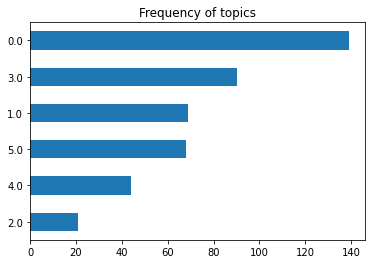

In [16]:
#Frequency Table
import matplotlib.pyplot as plt
df_dominant_topic["Dominant_Topic"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of topics")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


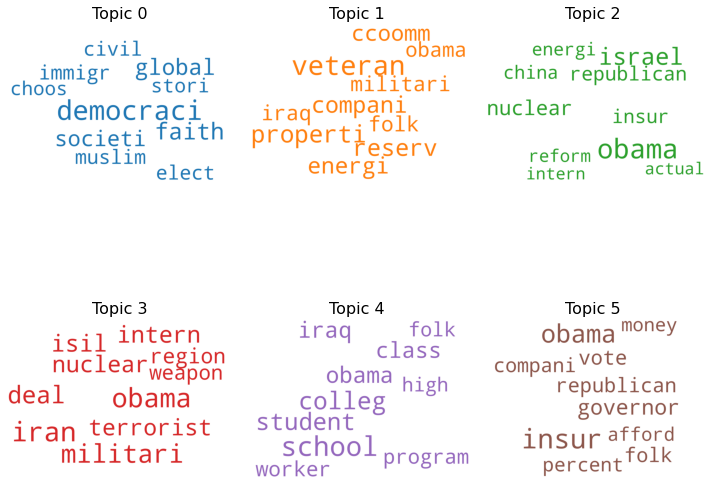

In [17]:
# Wordcloud of Top N words in each topic
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [18]:
%%capture --no-display
!pip install pyLDAvis

In [23]:
#PYLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,bow_corpus,dictionary=lda_model.id2word)
vis
warnings.filterwarnings('ignore')

![PyTorch Logo](https://raw.githubusercontent.com/s853348481/Obama_Speech_NLP/main/MDA_datasets/pyLDAvis.png)

In [27]:
pip freeze requirements.txt

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==2.1.9
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
clikit==0.6.2
cloudpickle==1.3.0
cmake==3.22.6
cmdstanpy==1.0.4
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2.12.0
datascience==0.17.5
debugpy==1.0.0
decora